In [1]:
config_file = "/users/kcochran/projects/new_procap_models/modisco_out/procap/"
config_file += "K562/strand_merged_umap/2022-10-05_03-39-32_profile_in/config.json"

In [2]:
# need to specify for every expt

patterns_to_keep = [0,1,2,3,4,5,7,8,9,10,13,14,15]

profile_to_counts_patterns = {0:[2,5], 1:None, 2:[0,1], 3:7, 4:3, 5:4, 7:9,
                              8:None, 9:None, 10:10, 13:6, 14:-1, 15:None}

In [3]:
import os
import numpy as np
import sys
sys.path.append("../2_train_models")
sys.path.append("../5_modisco")
from utils import load_json
from report_utils import load_modisco_results
from motif_hits_utils import import_motif_hits, filter_peak_hits_by_fdr
from modiscolite_utils import load_sequences, load_scores, load_observed_profiles
from plot_utils import get_continuous_cmap
import gzip
from file_configs import ValFilesConfig, TrainFilesConfig
import logomaker
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict

%matplotlib inline

from report_utils import pfm_info_content

config = load_json(config_file)

proj_dir = config["proj_dir"]

cell_type = config["cell_type"]
model_type = config["model_type"]
timestamp = config["timestamp"]
data_type = config["data_type"]

genome_path = config["genome_path"]
chrom_sizes = config["chrom_sizes"]

in_window = config["in_window"]
out_window = config["out_window"]

slice_len = config["slice"]

peak_path = config["train_val_peak_path"]

scores_path = config["scores_path"]

modisco_results_path = config["results_save_path"]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [92]:
fig_save_path = proj_dir + "figures/Fig2/"
os.makedirs(fig_save_path, exist_ok=True)

In [4]:
from motif_hits_utils import load_coords

coords = load_coords(peak_path, in_window=in_window)

In [5]:
onehot_seqs = load_sequences(genome_path,
                             chrom_sizes,
                             peak_path,
                             slice_len=slice_len,
                             in_window=in_window)

scores = load_scores(scores_path,
                     slice_len=slice_len,
                     in_window=in_window)

modisco_results = load_modisco_results(modisco_results_path)

counts_modisco_results = load_modisco_results(modisco_results_path.replace("profile", "counts"))

# need filepaths from these
train_config = TrainFilesConfig(cell_type, model_type, timestamp, data_type)
val_config = ValFilesConfig(cell_type, model_type, timestamp, data_type)

true_profs = load_observed_profiles(train_config.plus_bw_path,
                                    train_config.minus_bw_path,
                                    peak_path,
                                    slice_len=slice_len,
                                    out_window=out_window)

pred_profs = np.exp(np.load(val_config.pred_profiles_train_val_path))

Loading genome sequence from /mnt/lab_data2/kcochran/new_procap_models/genomes/hg38.withrDNA.fasta
== In Extract Sequences ==
Peak filepath: /mnt/lab_data2/kcochran/new_procap_models/deepshap_out/procap/K562/strand_merged_umap/2022-10-05_03-39-32_in/peaks_uni_and_bi_train_and_val.bed.gz
Sequence length: 2114
Num. Examples: 27000
Timestamp: 2022-10-05_03-39-32
Timestamp: 2022-10-05_03-39-32
== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/new_procap_models/deepshap_out/procap/K562/strand_merged_umap/2022-10-05_03-39-32_in/peaks_uni_and_bi_train_and_val.bed.gz
Profile length: 1000
Num. Examples: 27000


In [6]:
len(coords), onehot_seqs.shape, scores.shape, true_profs.shape, pred_profs.shape

(27000, (27000, 1000, 4), (27000, 1000, 4), (27000, 2, 1000), (27000, 2, 1000))

In [7]:
### Load Motifs

from motif_hits_utils import import_motif_hits, filter_peak_hits_by_fdr, make_peak_table, get_peak_hits_with_fix, get_peak_motif_counts

# this function differs slightly from Fig1.ipynb; to-do: standardize input for this

def load_motif_hits(modisco_results_path, train_val_peak_path, in_window, fdr_cutoff=0.05):
    modisco_hits_path = os.path.join(os.path.dirname(modisco_results_path), "motif_hits.bed")
    
    hits = import_motif_hits(modisco_hits_path)
    motif_keys = list(set(hits["key"]))

    # Filter motif hit table by p-value using FDR estimation
    filtered_hits = filter_peak_hits_by_fdr(hits, fdr_cutoff=fdr_cutoff)

    train_val_peak_table = make_peak_table(train_val_peak_path, in_window)

    # Match peaks to motif hits
    peak_hits = get_peak_hits_with_fix(train_val_peak_table, filtered_hits)

    # Count hits of each motif in each peak
    peak_hit_counts = get_peak_motif_counts(peak_hits, motif_keys)
    
    return filtered_hits, peak_hits, peak_hit_counts


motif_hits, motif_hits_peaks, motif_hit_counts = load_motif_hits(modisco_results_path, peak_path, in_window)

In [8]:
def get_n_seqlets_for_pattern(modisco_results, pattern_i):
    if pattern_i < 0:
        pattern_type = "neg_patterns"
        pattern_i = np.abs(pattern_i) - 1
    else:
        pattern_type = "pos_patterns"
    
    patterns = modisco_results[pattern_type]
    pattern_name = "pattern_" + str(pattern_i)
    return patterns[pattern_name]["seqlets"]['n_seqlets'][:][0]
    

def get_counts_task_seqlets(counts_modisco_results, profile_to_counts_patterns):
    seqlet_counts = dict()
    for profile_key, counts_patterns in profile_to_counts_patterns.items():
        if counts_patterns is None:
            seqlet_counts[profile_key] = np.nan
        elif type(counts_patterns) == int:
            seqlet_counts[profile_key] = get_n_seqlets_for_pattern(counts_modisco_results, counts_patterns)
        else:
            n_seqlets = 0
            for counts_pattern in counts_patterns:
                n_seqlets += get_n_seqlets_for_pattern(counts_modisco_results, counts_pattern)
            seqlet_counts[profile_key] = n_seqlets
    return seqlet_counts

counts_seqlets = get_counts_task_seqlets(counts_modisco_results, profile_to_counts_patterns)

In [106]:
def plot_motif(array, ax):
    df = pd.DataFrame(array, columns=['A', 'C', 'G', 'T'])
    df.index.name = 'pos'

    # "baseline_width=0" removes the y=0 line
    crp_logo = logomaker.Logo(df, ax=ax, font_name='Arial Rounded', baseline_width=0)
    crp_logo.style_spines(visible=False)
    ax.set_ylim(min(df.sum(axis=1).min(), 0), df.sum(axis=1).max())
    ax.set_xticks([])
    ax.set_yticks([])
    

def trim_motif_by_thresh(pfm, trim_threshold=0.3, pad=2):
    trim_thresh = np.max(pfm) * trim_threshold
    pass_inds = np.where(pfm >= trim_thresh)[0]

    start = max(np.min(pass_inds) - pad, 0)
    end = min(np.max(pass_inds) + pad + 1, len(pfm) + 1)
    
    return pfm[start:end]


def plot_avg_profile(profiles, ax, prof_width = 200, bottom_ticks=False):
    assert len(profiles.shape) == 3

    profiles = profiles[~np.isnan(profiles).any(axis=1).any(axis=1)]
    profiles = profiles[~np.isnan(profiles).any(axis=1).any(axis=1)]

    # First, normalize the profiles along the output profile dimension
    def normalize(arr, axis=0):
        arr_sum = np.sum(arr, axis=axis, keepdims=True)
        arr_sum[arr_sum == 0] = 1  # If 0, keep 0 as the quotient instead of dividing by 0
        return arr / arr_sum
    
    profs_norm = normalize(profiles, axis=-1)

    # Compute the mean profiles across all examples
    profs_mean = np.mean(profs_norm, axis=0)

    # Plot the average predictions
    prof_center = profs_mean.shape[-1] // 2
    ax.plot(profs_mean[0, prof_center - prof_width:prof_center + prof_width],
            color="#480CA8", linewidth=0.5)
    ax.plot(-profs_mean[1, prof_center - prof_width:prof_center + prof_width],
            color="#4361EE", linewidth=0.5)

    # Set axes
    max_mean_val = np.max(profs_mean)
    mean_ylim = max_mean_val * 1.1  # Make 5% higher
    ax.set_ylim(-mean_ylim, mean_ylim)
    ax.set_xlim(0, 2 * prof_width)
    ax.label_outer()
    ax.set_yticks([])
    
    if not bottom_ticks:
        ax.set_xticks([])
        for side in ["left", "top", "right", "bottom"]:
            ax.spines[side].set_visible(False)
    else:
        ax.set_xticks([prof_width, 2 * prof_width], [0, prof_width],
                     fontsize=6)
        ax.tick_params("x", length=3)
        
        for side in ["left", "top", "right"]:
            ax.spines[side].set_visible(False)
            
        rect = patches.Rectangle((0, -mean_ylim * 1.1), prof_width - 4, mean_ylim / 5,
                                 clip_on=False, zorder=50, color="white")
        ax.add_patch(rect)
            
        ax.spines['bottom'].set_position(('data', -mean_ylim))
        ax.spines["bottom"].set_color("#333333")
        

def extract_profs_at_motifs(motif_hits, coords, true_profs, pred_profs,
                             in_window, out_window, slice_len, prof_width=200):
        
    def convert_motif_coords_to_prof_coords(coords, coord_indexes, motif_starts, motif_ends):
        real_starts = []
        real_ends = []
        for peak_index, start, end in zip(coord_indexes, motif_starts, motif_ends):
            peak_coords = coords[peak_index]
            peak_start, peak_end = peak_coords[1:3]
            real_start = start - peak_start - (in_window - out_window) // 2
            real_starts.append(real_start)
            real_ends.append(real_start + (end - start))
        return np.array(real_starts), np.array(real_ends)
        
    coord_indexes = motif_hits["peak_index"]
    motif_starts = motif_hits["start"]
    motif_ends = motif_hits["end"]
    motif_rcs = motif_hits["strand"] == "-"
    
    motif_starts, motif_ends = convert_motif_coords_to_prof_coords(coords, coord_indexes,
                                                                   motif_starts, motif_ends)
    
    # Get indices of profile above motif
    motif_centers = (motif_starts + motif_ends) // 2
    motif_prof_starts = motif_centers - prof_width
    motif_prof_ends = motif_centers + prof_width
    
    # For each seqlet, fetch the true/predicted profiles
    true_motif_profs = []
    pred_motif_profs = []
    for coord_index, prof_start, prof_end, rc in zip(coord_indexes, motif_prof_starts, motif_prof_ends, motif_rcs):
        if not (prof_start < 0 or prof_end > out_window):
            true_prof = true_profs[coord_index, :, prof_start:prof_end]
            pred_prof = pred_profs[coord_index, :, prof_start:prof_end]
            if rc:
                true_prof = true_prof[::-1, ::-1]
                pred_prof = pred_prof[::-1, ::-1]
        
            true_motif_profs.append(true_prof)
            pred_motif_profs.append(pred_prof)

    true_motif_profs = np.stack(true_motif_profs)
    pred_motif_profs = np.stack(pred_motif_profs)
    
    return true_motif_profs, pred_motif_profs
    
    
def extract_profs_at_seqlets(seqlets, coords, true_profs, pred_profs,
                             in_window, out_window, slice_len, prof_width=200):
        
    def seqlet_coord_to_input_coord(seqlet_coord):
        return seqlet_coord + ((in_window - slice_len) // 2)
        
    def convert_seqlet_coords_to_genomic_coords(coord_indexes, seqlet_starts, seqlet_ends, pred_coords):
        input_starts = seqlet_coord_to_input_coord(seqlet_starts)
        input_ends = seqlet_coord_to_input_coord(seqlet_ends)
        
        genomic_coords = []
        for coord_index, input_start, input_end in zip(coord_indexes, input_starts, input_ends):
            chrom, peak_start, _, _, _ = pred_coords[coord_index]
            genomic_coords.append([chrom, peak_start + input_start, peak_start + input_end])
            
        return genomic_coords
    
    def seqlet_coord_to_profile_coord(seqlet_coord):
        return seqlet_coord + ((in_window - slice_len) // 2) - ((in_window - out_window) // 2)
        
    coord_indexes = seqlets["example_idx"][:]
    seqlet_starts = seqlets["start"][:]
    seqlet_ends = seqlets["end"][:]
    seqlet_rcs = seqlets["is_revcomp"][:]
    
    # Get indices of profile above seqlet
    seqlet_centers = (seqlet_starts + seqlet_ends) // 2
    prof_centers = seqlet_coord_to_profile_coord(seqlet_centers)
    prof_starts = prof_centers - prof_width
    prof_ends = prof_starts + prof_width * 2
    
    # For each seqlet, fetch the true/predicted profiles
    true_seqlet_profs = []
    pred_seqlet_profs = []
    for coord_index, prof_start, prof_end, rc in zip(coord_indexes, prof_starts, prof_ends, seqlet_rcs):
        if prof_start < 0 or prof_end > out_window:
            # don't use profile for this example since indexes go past the profile end  - Kelly
            true_prof = np.full((true_profs.shape[-2], prof_width * 2), np.nan)
            pred_prof = np.full((true_profs.shape[-2], prof_width * 2), np.nan)
        else:
            true_prof = true_profs[coord_index, :, prof_start:prof_end]
            pred_prof = pred_profs[coord_index, :, prof_start:prof_end]
        
        if rc:
            true_prof = true_prof[::-1, ::-1]
            pred_prof = pred_prof[::-1, ::-1]
        
        true_seqlet_profs.append(true_prof)
        pred_seqlet_profs.append(pred_prof)  
    
    true_seqlet_profs = np.stack(true_seqlet_profs)
    pred_seqlet_profs = np.stack(pred_seqlet_profs)
    
    return true_seqlet_profs, pred_seqlet_profs

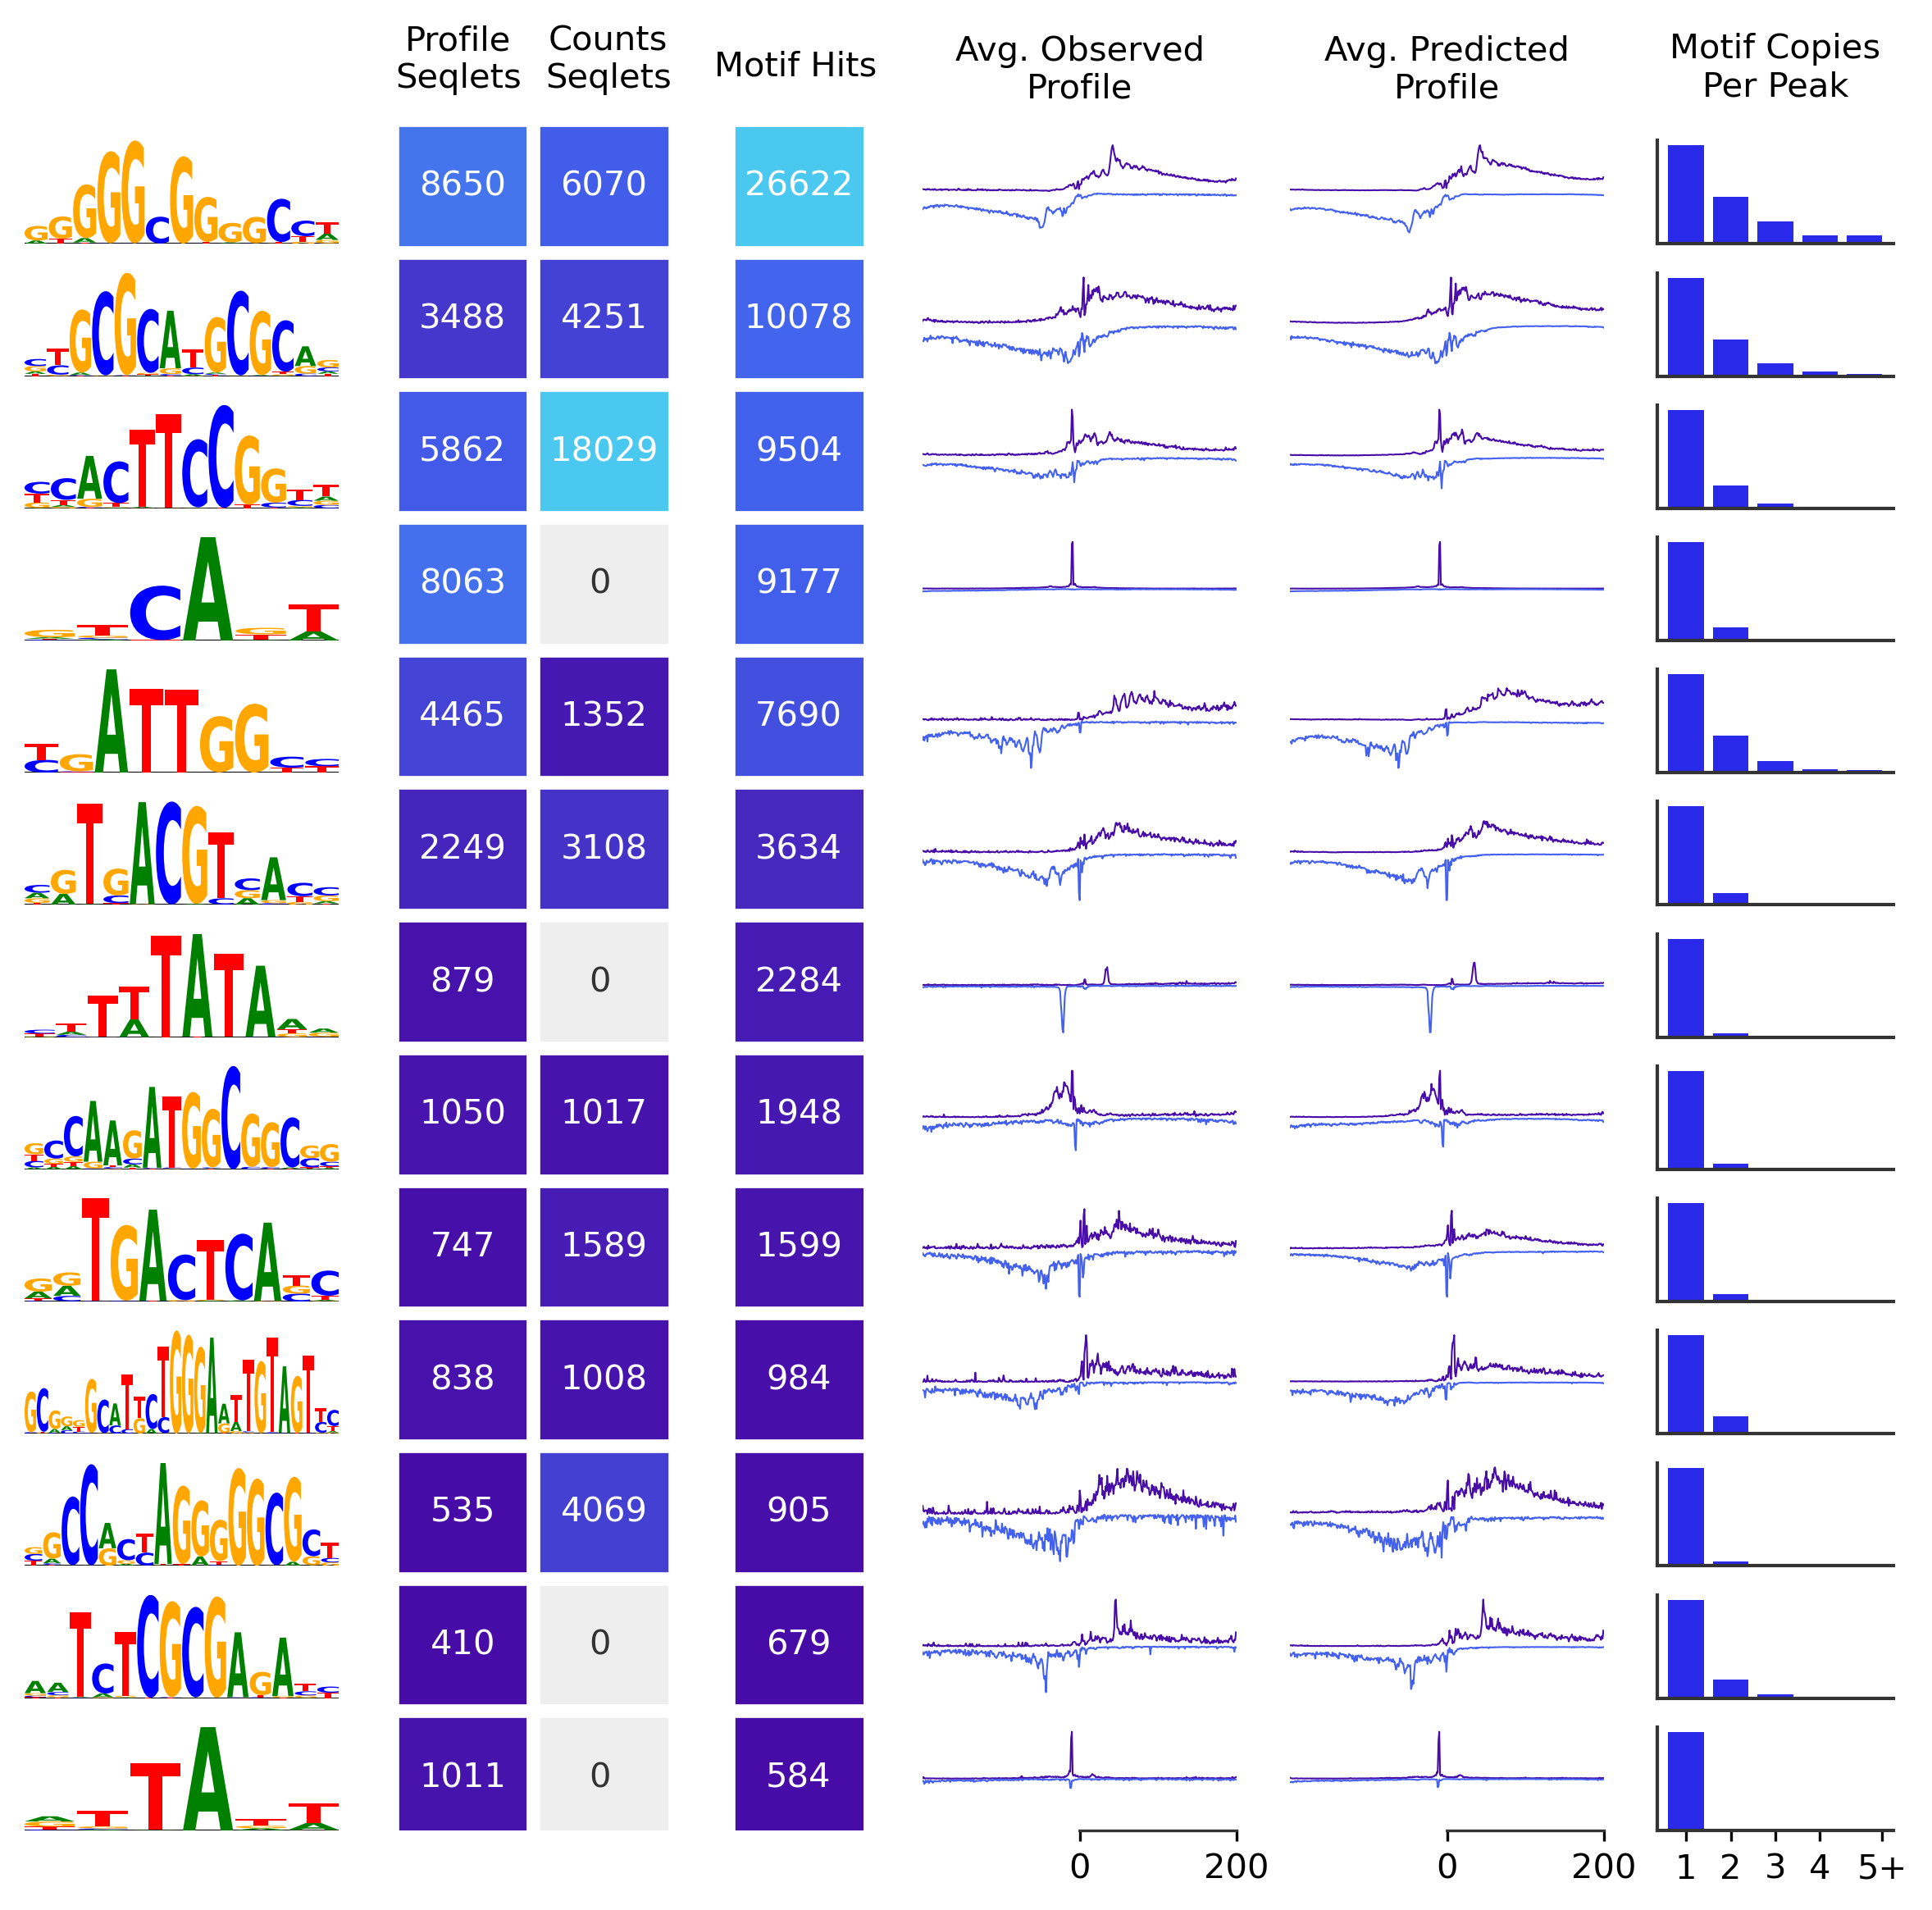

In [94]:
from collections import defaultdict

def plot_modisco_hits(modisco_results, counts_seqlets,
                      patterns_to_keep, motif_hits, motif_hit_counts,
                      coords, true_profs, pred_profs, 
                      in_window, out_window, slice_len,
                      prof_width=200, save_path=None):

    pattern_type = "pos_patterns"
    patterns = modisco_results[pattern_type]

    ### first, load up all the data used in the plot
    
    cwms = []
    seqlet_heatmap_data = defaultdict(lambda : [])
    true_profs_list = []
    pred_profs_list = []
    hist_ys = []
    hist_xs = []
    for ax_row_i, pattern_i in enumerate(patterns_to_keep):
        
        pattern_name = "pattern_" + str(pattern_i)
        pattern = patterns[pattern_name]

        cwm = pattern["contrib_scores"][:]
        cwms.append(cwm)

        seqlets = pattern["seqlets"]
        seqlet_heatmap_data["profile"].append(seqlets['n_seqlets'][:][0])
        seqlet_heatmap_data["counts"].append(counts_seqlets[pattern_i])

        # do ax_row_i here because the motif hit caller only saw filtered subset of motifs
        motif_hits_subset = motif_hits[motif_hits["key"] == ax_row_i]

        true_motif_profs, pred_motif_profs = extract_profs_at_motifs(motif_hits_subset, coords,
                                                                     true_profs, pred_profs,
                                                                     in_window, out_window,
                                                                     slice_len, prof_width=200)
        true_profs_list.append(true_motif_profs)
        pred_profs_list.append(pred_motif_profs)

        hist_y, hist_x = np.histogram([num for num in motif_hit_counts[:, ax_row_i] if num > 0],
                                      bins=range(1, np.max(motif_hit_counts)))
        hist_ys.append(hist_y)
        hist_xs.append(hist_x)

        
    ### sort everything identically
        
    heatmap2_data = motif_hit_counts.sum(axis=0)
    
    sort_order = np.argsort(heatmap2_data)[::-1]
    
    heatmap2_data = heatmap2_data[sort_order]
    cwms = np.array(cwms)[sort_order]
    true_profs_list = np.array(true_profs_list, dtype=object)[sort_order]
    pred_profs_list = np.array(pred_profs_list, dtype=object)[sort_order]
    hist_ys = np.array(hist_ys, dtype=object)[sort_order]
    hist_xs = np.array(hist_xs, dtype=object)[sort_order]
    for key in seqlet_heatmap_data.keys():
        seqlet_heatmap_data[key] = np.array(seqlet_heatmap_data[key])[sort_order]
        
        
    ### with data all loaded, start building plot

    fig, axes = plt.subplots(len(patterns_to_keep) + 1, 6,
                             figsize=(9.8,0.7 * len(patterns_to_keep)),
                             dpi=300,
                             gridspec_kw={"width_ratios":[2,1.8,0.9,2,2,1.5],
                                          "height_ratios":[0.05] + [1] * len(patterns_to_keep),
                                          "hspace":0.3, "wspace":0.2})

    # the top and bottom row of subplots are fake (for padding), so remove/hide
    axes[0,0].remove()
    for ax in axes[0, 2:]:
        ax.remove()
    axes[0,1].set_axis_off()

    # modify the subplot arrangement to draw heatmap over a whole column
    gs1 = axes[0,1].get_gridspec()
    gs2 = axes[0,2].get_gridspec()
    for ax in axes[1:, 1]:
        ax.remove()
    for ax in axes[1:, 2]:
        ax.remove()
    heatmap1 = fig.add_subplot(gs1[:, 1])
    heatmap2 = fig.add_subplot(gs2[:, 2])

    for ax_row_i in range(len(patterns_to_keep)):
        cwm = cwms[ax_row_i]
        true_profs = true_profs_list[ax_row_i]
        pred_profs = pred_profs_list[ax_row_i]
        hist_y = hist_ys[ax_row_i]
        hist_x = hist_xs[ax_row_i]
        
        ### plot motif CWM, true/pred profiles
        ax_row = axes[ax_row_i+1]
        
        plot_motif(trim_motif_by_thresh(cwm), ax_row[0])

        plot_avg_profile(true_profs, ax_row[3],
                         prof_width = prof_width,
                         bottom_ticks = ax_row_i == len(patterns_to_keep)-1)
        if ax_row_i == 0:
            ax_row[3].set_title("Avg. Observed\nProfile\n", fontsize=10, pad=1.5)

        plot_avg_profile(pred_profs, ax_row[4],
                         prof_width = prof_width,
                         bottom_ticks = ax_row_i == len(patterns_to_keep)-1)
        if ax_row_i == 0:
            ax_row[4].set_title("Avg. Predicted\nProfile\n", fontsize=10, pad=1.5)

        ### plot motif complexity histograms
            
        stop_after = 4
        hist_y = list(hist_y[:stop_after]) + [np.sum(hist_y[stop_after:])]
        hist_x = list(hist_x[:stop_after + 1])
        ax_row[5].bar(hist_x, hist_y, color="#2929ea", alpha=1)

        ax_row[5].tick_params("both", length=3)
        ax_row[5].set_yticks([])
        if ax_row_i == len(patterns_to_keep) - 1:
            xticks = hist_x[:-1] + [hist_x[-1] + 0.4]
            xticklabels = [str(i) for i in hist_x[:-1]]
            xticklabels.append(str(hist_x[-1]) + "+")
            ax_row[5].set_xticks(xticks, xticklabels)
        else:
            ax_row[5].set_xticks([])

        for side in ["left", "bottom"]:
            ax_row[5].spines[side].set_linewidth(1)
            ax_row[5].spines[side].set_color("#333333")
        for side in ["top", "right"]:
            ax_row[5].spines[side].set_visible(False)
            
        if ax_row_i == 0:
            ax_row[5].set_title("Motif Copies\nPer Peak\n", fontsize=10, pad=1.5)

    ### plot heatmaps (columns 2 and 3)

    cmap = get_continuous_cmap(["#480CA8", "#4361EE", "#4895EF", "#4CC9F0"])
    cmap.set_bad(color='#EEEEEE')
    heatmap1_data = np.array((seqlet_heatmap_data["profile"],
                              seqlet_heatmap_data["counts"])).T
    heatmap1.imshow(heatmap1_data, aspect = "auto", cmap=cmap)

    heatmap1.set_xticks(np.arange(3)-.5, minor=True)
    heatmap1.xaxis.set_ticks_position("top")
    heatmap1.set_xticks([-0.03,1.03], ["Profile\nSeqlets", "Counts\nSeqlets"], fontsize=10)
    heatmap1.tick_params(pad=0)

    # hack to fix weird line in plot (only actually shows one column)
    heatmap2.imshow(np.array((heatmap2_data, heatmap2_data)).T,
                 aspect = "auto", cmap=cmap)
    heatmap2.set_xticks(np.arange(0,2,2)-.5, minor=True)
    heatmap2.xaxis.set_ticks_position("top")
    heatmap2.set_xticks([0.5], ["Motif Hits"], fontsize=10)

    # format heatmaps to look better
    for heatmap in [heatmap1, heatmap2]:
        heatmap.grid(which="minor", color="w", linestyle='-', linewidth=4)
        heatmap.tick_params(which="minor", bottom=False, left=False, top=False)
        heatmap.tick_params(which="major", bottom=False, left=False, top=False)
        #heatmap.set_xticklabels([])
        heatmap.set_yticklabels([])
        for side in ["left", "top", "right", "bottom"]:
            heatmap.spines[side].set_visible(False)

        heatmap.set_yticks(np.arange(len(heatmap1_data)+1)-.5, minor=True)
        heatmap.set_ylim(len(heatmap1_data) - 0.6, -0.6)

    heatmap1.set_xlim(-0.5, 1.5)
    heatmap2.set_xlim(-0.5, 1.6)

    # add text on top of heatmaps
    for i in range(heatmap1_data.shape[0]):
        for j in range(heatmap1_data.shape[1]):
            if not np.isnan(heatmap1_data[i,j]):
                text = heatmap1.text(j, i, int(heatmap1_data[i,j]),
                           ha="center", va="center", color="w", fontsize=10)
            else:
                text = heatmap1.text(j-0.03, i, 0,
                           ha="center", va="center", color="#333333", fontsize=10)

    for i in range(heatmap2_data.shape[0]):
        text = heatmap2.text(j - 0.45, i, int(heatmap2_data[i]),
                           ha="center", va="center", color="w", fontsize=10)

    if save_path is not None:
        plt.savefig(save_path)#, dpi=300)
        
    plt.show()
        
            
plot_modisco_hits(modisco_results, counts_seqlets,
                  patterns_to_keep, motif_hits, motif_hit_counts,
                  coords, true_profs, pred_profs,
                  in_window, out_window, slice_len,
                  save_path = fig_save_path + "main.png")

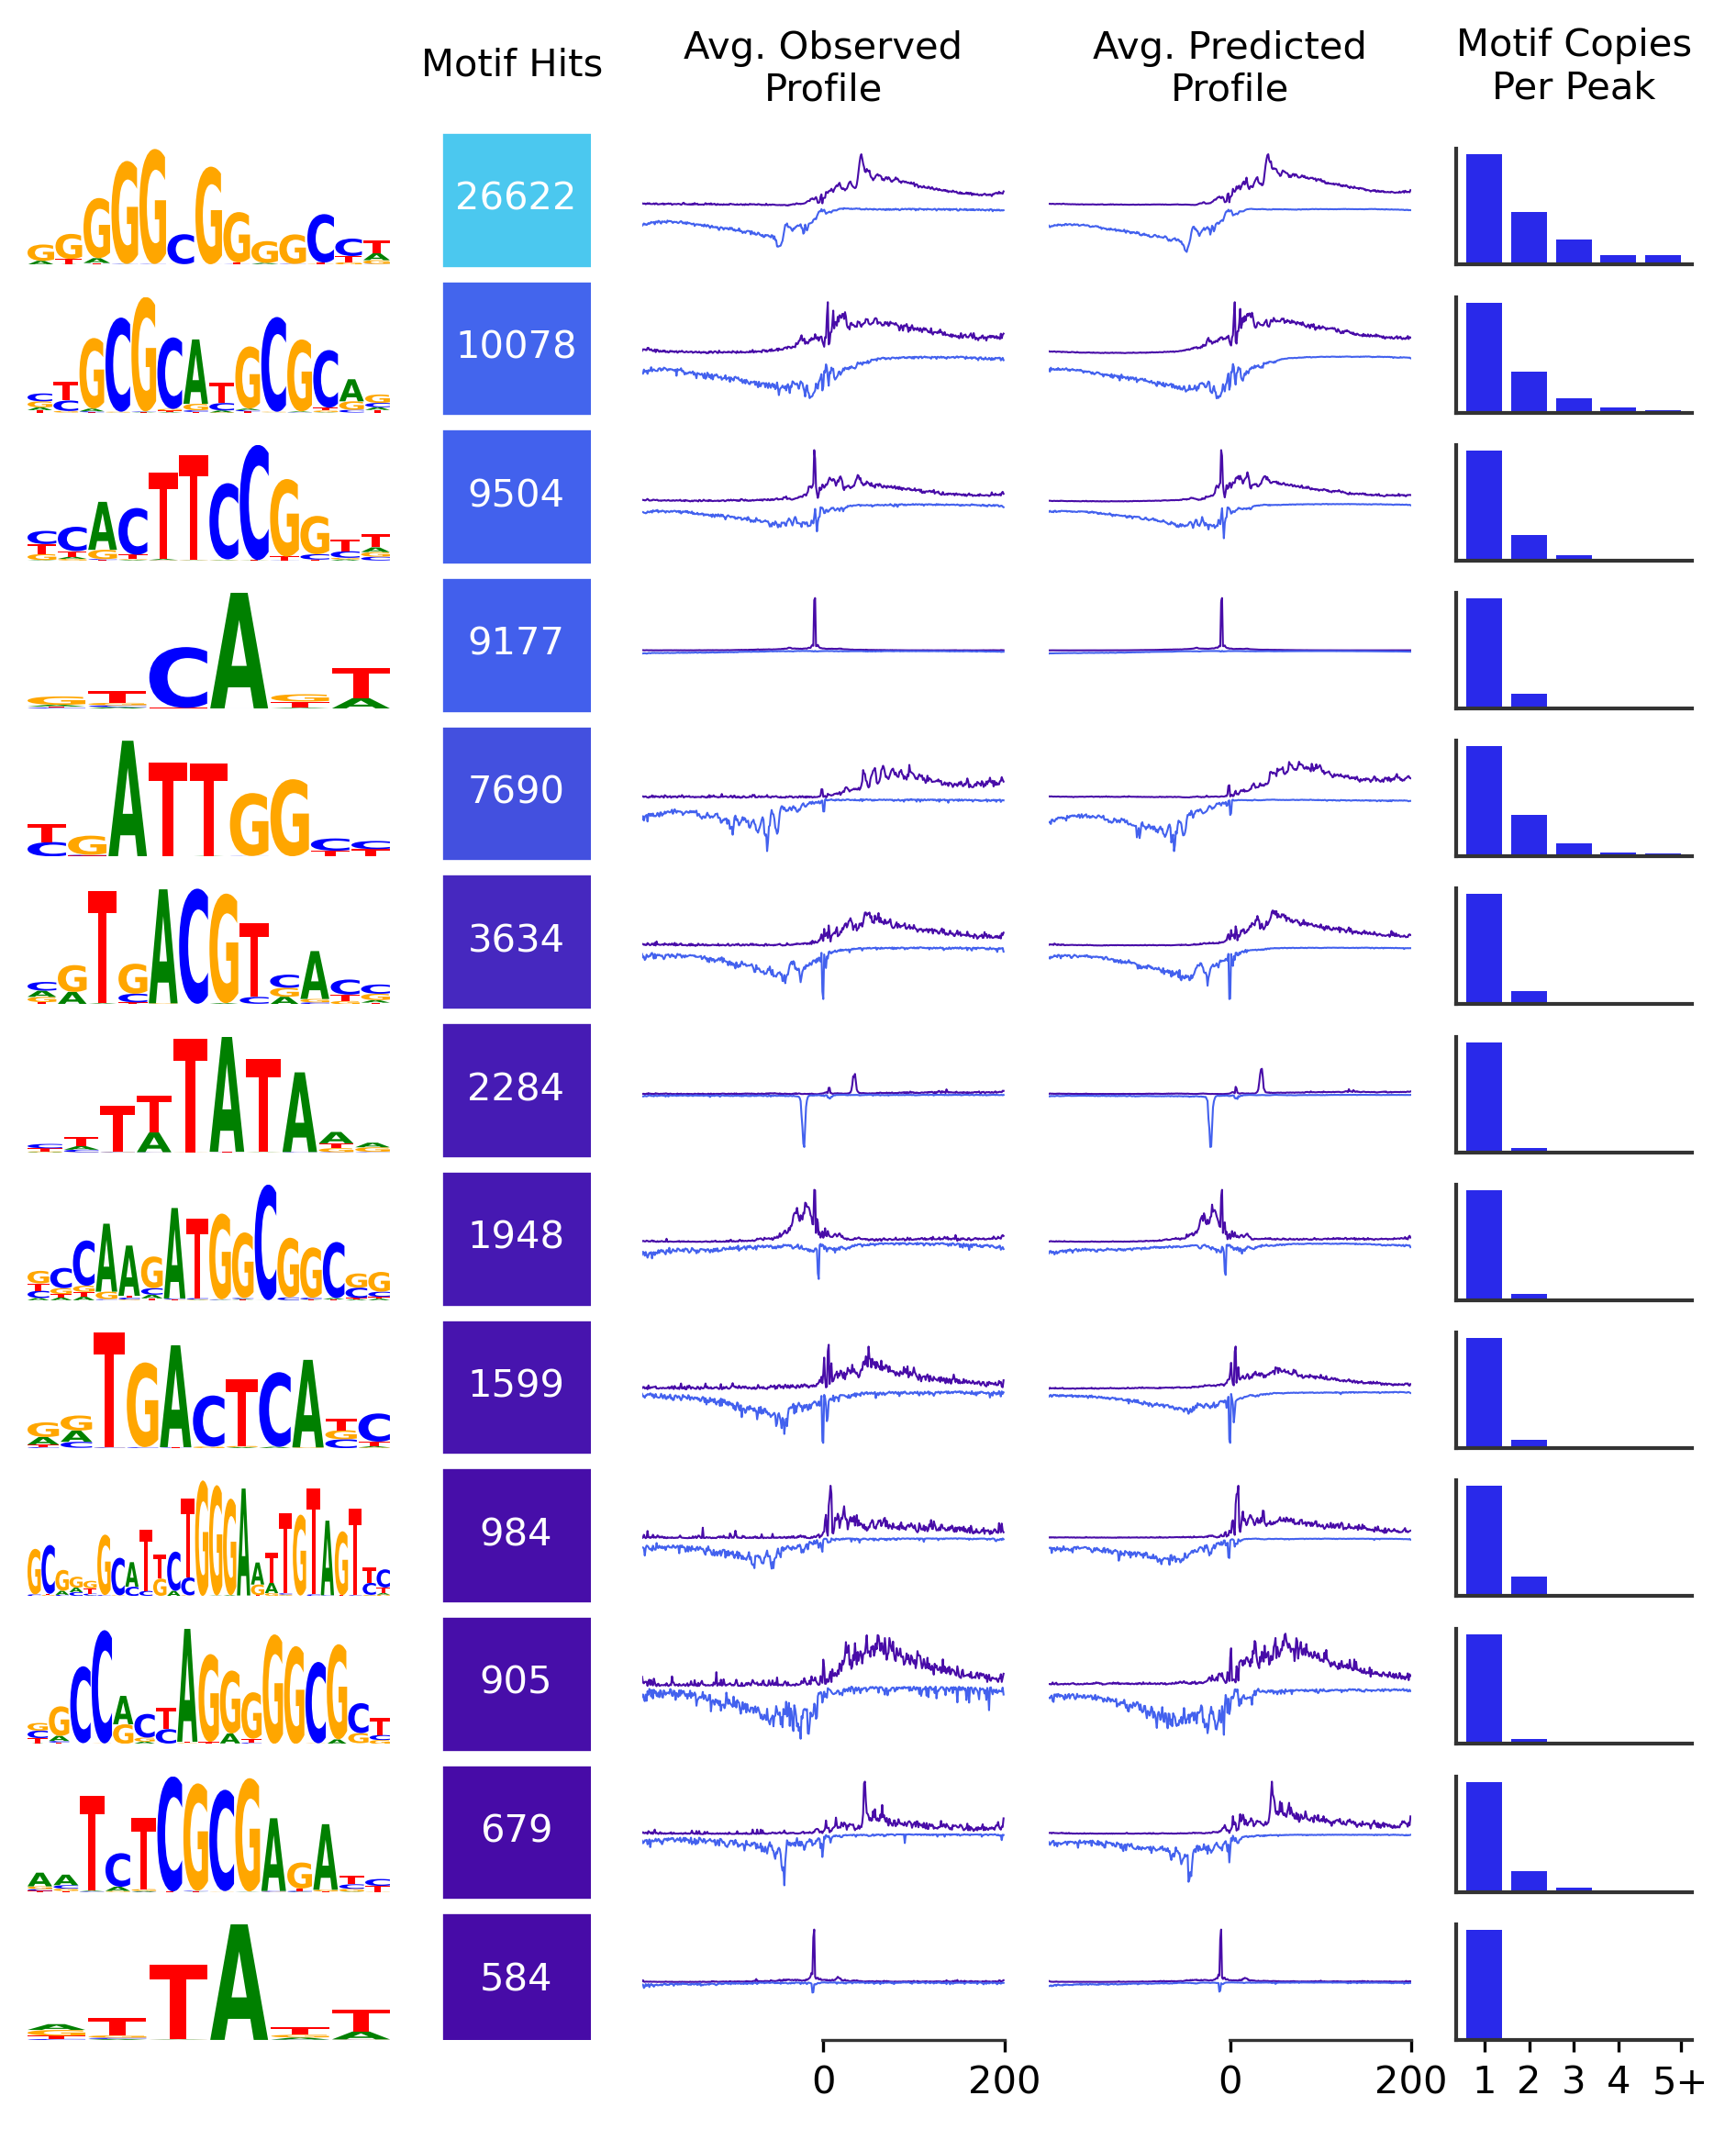

In [117]:
### same as above, but no seqlet info plotted

def plot_modisco_hits_v2(modisco_results, counts_seqlets,
                      patterns_to_keep, motif_hits, motif_hit_counts,
                      coords, true_profs, pred_profs, 
                      in_window, out_window, slice_len,
                      prof_width=200, save_path=None):

    pattern_type = "pos_patterns"
    patterns = modisco_results[pattern_type]

    ### first, load up all the data used in the plot
    
    cwms = []
    seqlet_heatmap_data = defaultdict(lambda : [])
    true_profs_list = []
    pred_profs_list = []
    hist_ys = []
    hist_xs = []
    for ax_row_i, pattern_i in enumerate(patterns_to_keep):
        
        pattern_name = "pattern_" + str(pattern_i)
        pattern = patterns[pattern_name]

        cwm = pattern["contrib_scores"][:]
        cwms.append(cwm)

        seqlets = pattern["seqlets"]
        seqlet_heatmap_data["profile"].append(seqlets['n_seqlets'][:][0])
        seqlet_heatmap_data["counts"].append(counts_seqlets[pattern_i])

        # do ax_row_i here because the motif hit caller only saw filtered subset of motifs
        motif_hits_subset = motif_hits[motif_hits["key"] == ax_row_i]

        true_motif_profs, pred_motif_profs = extract_profs_at_motifs(motif_hits_subset, coords,
                                                                     true_profs, pred_profs,
                                                                     in_window, out_window,
                                                                     slice_len, prof_width=200)
        true_profs_list.append(true_motif_profs)
        pred_profs_list.append(pred_motif_profs)

        hist_y, hist_x = np.histogram([num for num in motif_hit_counts[:, ax_row_i] if num > 0],
                                      bins=range(1, np.max(motif_hit_counts)))
        hist_ys.append(hist_y)
        hist_xs.append(hist_x)

        
    ### sort everything identically
        
    heatmap2_data = motif_hit_counts.sum(axis=0)
    
    sort_order = np.argsort(heatmap2_data)[::-1]
    
    heatmap2_data = heatmap2_data[sort_order]
    cwms = np.array(cwms)[sort_order]
    true_profs_list = np.array(true_profs_list, dtype=object)[sort_order]
    pred_profs_list = np.array(pred_profs_list, dtype=object)[sort_order]
    hist_ys = np.array(hist_ys, dtype=object)[sort_order]
    hist_xs = np.array(hist_xs, dtype=object)[sort_order]
    for key in seqlet_heatmap_data.keys():
        seqlet_heatmap_data[key] = np.array(seqlet_heatmap_data[key])[sort_order]
        
        
    ### with data all loaded, start building plot

    fig, axes = plt.subplots(len(patterns_to_keep)+1, 5,
                             figsize=(7.8,0.7 * len(patterns_to_keep)),
                             dpi=300,
                             gridspec_kw={"width_ratios":[2,0.9,2,2,1.3],
                                          "height_ratios":[0.05] + [1] * len(patterns_to_keep),
                                          "hspace":0.3, "wspace":0.15})

    # the top and bottom row of subplots are fake (for padding), so remove/hide
    axes[0,0].remove()
    for ax in axes[0, 2:]:
        ax.remove()
    axes[0,1].set_axis_off()

    # modify the subplot arrangement to draw heatmap over a whole column
    gs1 = axes[0,1].get_gridspec()
    for ax in axes[1:, 1]:
        ax.remove()

    heatmap2 = fig.add_subplot(gs1[:, 1])

    for ax_row_i in range(len(patterns_to_keep)):
        cwm = cwms[ax_row_i]
        true_profs = true_profs_list[ax_row_i]
        pred_profs = pred_profs_list[ax_row_i]
        hist_y = hist_ys[ax_row_i]
        hist_x = hist_xs[ax_row_i]
        
        ax_col_i = 0
        
        ### plot motif CWM, true/pred profiles
        ax_row = axes[ax_row_i+1]
        
        plot_motif(trim_motif_by_thresh(cwm), ax_row[ax_col_i])
        
        ax_col_i += 2  # skip heatmap column

        plot_avg_profile(true_profs, ax_row[ax_col_i],
                         prof_width = prof_width,
                         bottom_ticks = ax_row_i == len(patterns_to_keep)-1)
        if ax_row_i == 0:
            ax_row[ax_col_i].set_title("Avg. Observed\nProfile\n", fontsize=10, pad=1.5)

        ax_col_i += 1
            
        plot_avg_profile(pred_profs, ax_row[ax_col_i],
                         prof_width = prof_width,
                         bottom_ticks = ax_row_i == len(patterns_to_keep)-1)
        if ax_row_i == 0:
            ax_row[ax_col_i].set_title("Avg. Predicted\nProfile\n", fontsize=10, pad=1.5)

        ax_col_i += 1
            
        ### plot motif complexity histograms
            
        stop_after = 4
        hist_y = list(hist_y[:stop_after]) + [np.sum(hist_y[stop_after:])]
        hist_x = list(hist_x[:stop_after + 1])
        ax_row[ax_col_i].bar(hist_x, hist_y, color="#2929ea", alpha=1)

        ax_row[ax_col_i].tick_params("both", length=3)
        ax_row[ax_col_i].set_yticks([])
        if ax_row_i == len(patterns_to_keep) - 1:
            xticks = hist_x[:-1] + [hist_x[-1] + 0.4]
            xticklabels = [str(i) for i in hist_x[:-1]]
            xticklabels.append(str(hist_x[-1]) + "+")
            ax_row[ax_col_i].set_xticks(xticks, xticklabels)
        else:
            ax_row[ax_col_i].set_xticks([])

        for side in ["left", "bottom"]:
            ax_row[ax_col_i].spines[side].set_linewidth(1)
            ax_row[ax_col_i].spines[side].set_color("#333333")
        for side in ["top", "right"]:
            ax_row[ax_col_i].spines[side].set_visible(False)
            
        if ax_row_i == 0:
            ax_row[ax_col_i].set_title("Motif Copies\nPer Peak\n", fontsize=10, pad=1.5)

    ### plot heatmaps (column 2)
    
    cmap = get_continuous_cmap(["#480CA8", "#4361EE", "#4895EF", "#4CC9F0"])
    cmap.set_bad(color='#EEEEEE')

    # hack to fix weird line in plot (only actually shows one column)
    heatmap2.imshow(np.array((heatmap2_data, heatmap2_data)).T,
                 aspect = "auto", cmap=cmap)
    heatmap2.set_xticks(np.arange(0,2,2)-.5, minor=True)
    heatmap2.xaxis.set_ticks_position("top")
    heatmap2.set_xticks([0.5], ["Motif Hits"], fontsize=10)

    # format heatmaps to look better
    for heatmap in [heatmap2]:
        heatmap.grid(which="minor", color="w", linestyle='-', linewidth=4)
        heatmap.tick_params(which="minor", bottom=False, left=False, top=False)
        heatmap.tick_params(which="major", bottom=False, left=False, top=False)
        #heatmap.set_xticklabels([])
        heatmap.set_yticklabels([])
        for side in ["left", "top", "right", "bottom"]:
            heatmap.spines[side].set_visible(False)

        heatmap.set_yticks(np.arange(len(heatmap2_data)+1)-.5, minor=True)
        heatmap.set_ylim(len(heatmap2_data) - 0.6, -0.6)

    heatmap2.set_xlim(-0.5, 1.6)

    # add text on top of heatmaps

    for i in range(heatmap2_data.shape[0]):
        text = heatmap2.text(1- 0.45, i, int(heatmap2_data[i]),
                           ha="center", va="center", color="w", fontsize=10)

    if save_path is not None:
        plt.savefig(save_path, pad_inches=0, bbox_inches='tight')#, dpi=300)
        
    plt.show()
        
            
plot_modisco_hits_v2(modisco_results, counts_seqlets,
                  patterns_to_keep, motif_hits, motif_hit_counts,
                  coords, true_profs, pred_profs,
                  in_window, out_window, slice_len,
                  save_path = fig_save_path + "main_v2.png")

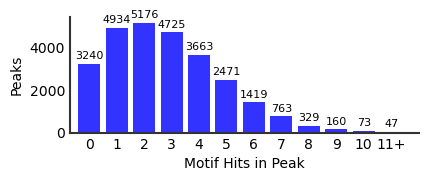

In [12]:
def plot_motif_complexity_in_peaks(motif_hit_counts):
    motif_hits_per_peak = motif_hit_counts.sum(axis=1)

    hist_y, hist_x = np.histogram(motif_hits_per_peak, bins=range(np.max(motif_hits_per_peak) + 2))
    
    stop_point = 11
    hist_y = list(hist_y[:stop_point]) + [np.sum(hist_y[stop_point:])]
    hist_x = list(hist_x[:stop_point]) + [stop_point]
    
    plt.figure(figsize=(4.5,1.5))
    plt.bar(hist_x, hist_y, color="blue", alpha=0.8)
    
    plt.xlabel("Motif Hits in Peak")
    plt.ylabel("Peaks")
    
    xticklabels = []
    for i in hist_x:
        if i < stop_point:
            xticklabels.append(str(i))
        else:
            xticklabels.append(str(stop_point) + "+")
            
    plt.xticks(hist_x, xticklabels)
    plt.xlim(-0.7, len(hist_x))
    plt.tick_params("both", length=0)
    
    ax = plt.gca()
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_color("#333333")
    ax.spines["bottom"].set_color("#333333")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    for c in ax.containers:
        ax.bar_label(c, fontsize=8, padding=2)
    
    plt.show()
    
plot_motif_complexity_in_peaks(motif_hit_counts)

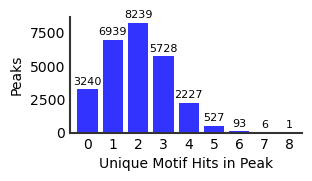

In [13]:
def plot_uniq_motif_complexity_in_peaks(motif_hit_counts):
    motif_hits_per_peak = (motif_hit_counts > 0).sum(axis=-1).astype(np.int32)

    hist_y, hist_x = np.histogram(motif_hits_per_peak, bins=range(motif_hit_counts.shape[1]))

    stop_point = 9
    hist_y = list(hist_y[:stop_point])
    hist_x = list(hist_x[:stop_point])
    
    plt.figure(figsize=(3,1.5))
    plt.bar(hist_x, hist_y, color="blue", alpha=0.8)
    
    plt.xlabel("Unique Motif Hits in Peak")
    plt.ylabel("Peaks")
    
    #xticklabels = [str(i) if i < 11 else "11-" + str(np.max(motif_hits_per_peak)) for i in hist_x]
    plt.xticks(hist_x)
    plt.xlim(-0.7, len(hist_x) - 0.5)
    plt.tick_params("both", length=0)
    
    ax = plt.gca()
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_color("#333333")
    ax.spines["bottom"].set_color("#333333")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    for c in ax.containers:
        ax.bar_label(c, fontsize=8, padding=2)
    
    plt.show()
    
plot_uniq_motif_complexity_in_peaks(motif_hit_counts)

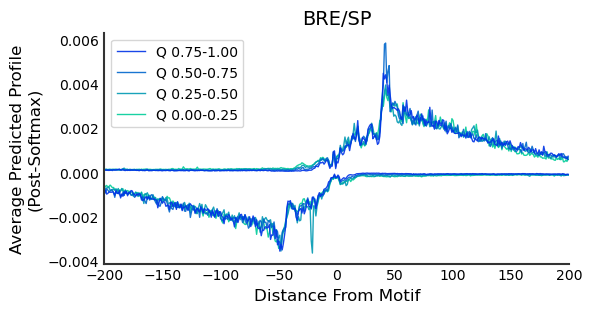

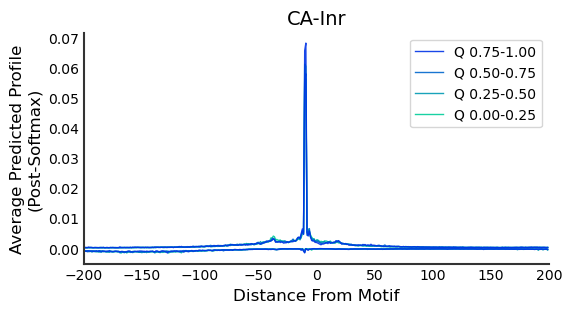

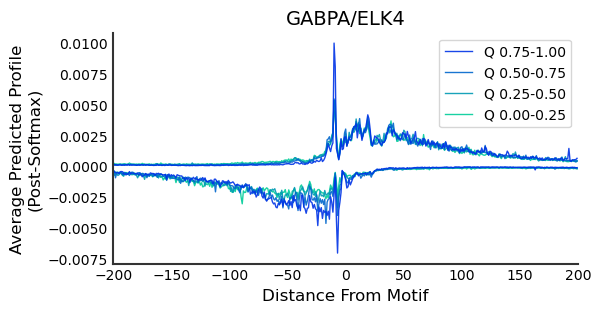

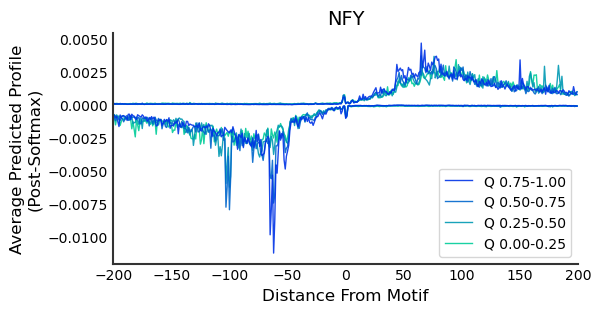

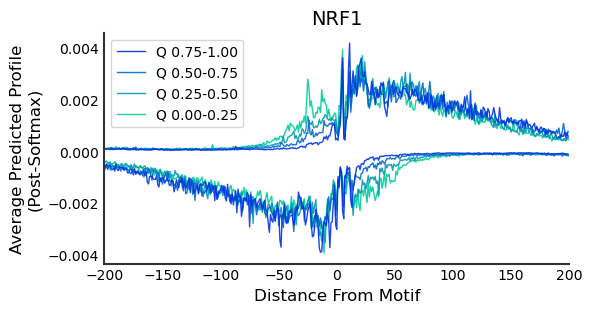

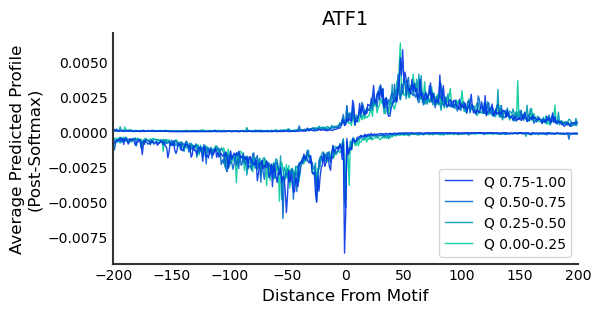

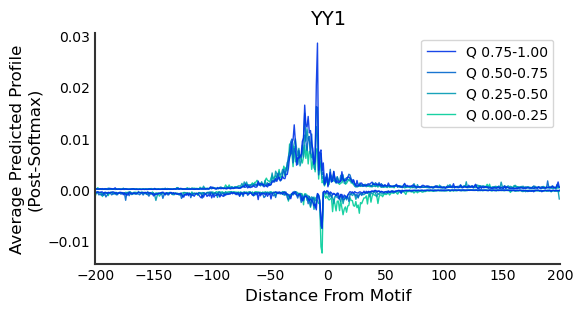

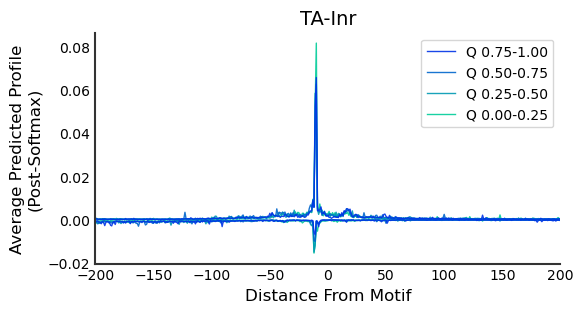

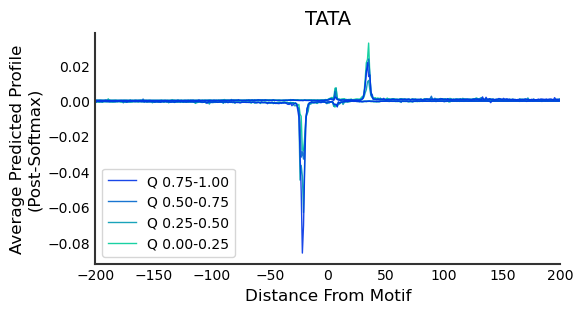

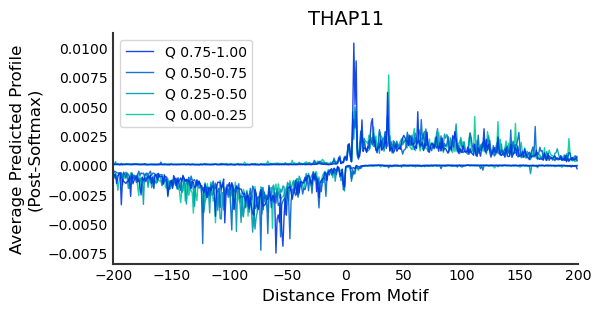

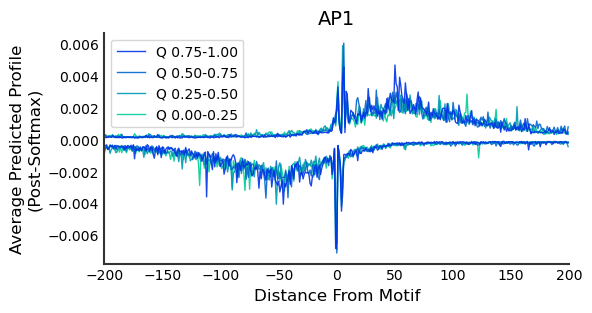

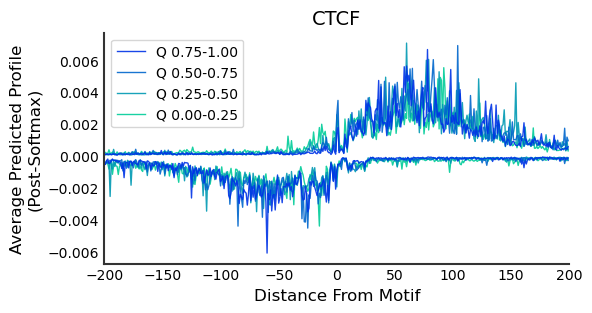

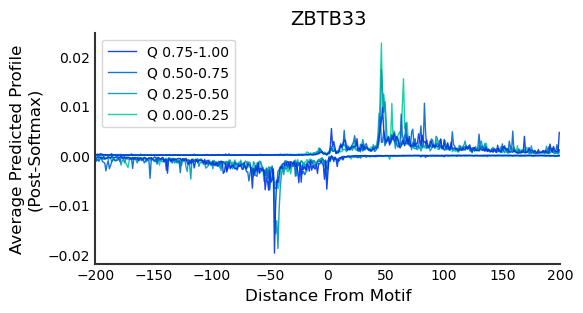

In [88]:
from data_loading import one_hot_encode
import matplotlib.colors as colors
import matplotlib.cm as cmx


# This is specific to K562

motif_keys_to_labels = ["BRE/SP", "CA-Inr", "GABPA/ELK4", "NFY", "NRF1", "ATF1",
                        "YY1", "TA-Inr", "TATA", "THAP11",
                        "AP1",  "CTCF", "ZBTB33"]



def score_seq_by_cwm(cwm, seq):
    if type(seq) == str:
        seq = one_hot_encode(seq)
    return np.multiply(seq, cwm).sum()


def extract_seqs_at_motifs(motif_hits, coords, onehot_seqs, in_window, buffer_width = 200):
        
    def convert_motif_coords_to_seq_coords(coords, coord_indexes, motif_starts, motif_ends):
        real_starts = []
        real_ends = []
        for peak_index, start, end in zip(coord_indexes, motif_starts, motif_ends):
            peak_coords = coords[peak_index]
            peak_start, peak_end = peak_coords[1:3]
            real_start = start - peak_start - (in_window - onehot_seqs.shape[1]) // 2
            real_starts.append(real_start)
            real_ends.append(real_start + (end - start))
            #print(peak_start, peak_end, start, end, real_start)
        return np.array(real_starts), np.array(real_ends)
        
    coord_indexes = motif_hits["peak_index"]
    motif_starts = motif_hits["start"]
    motif_ends = motif_hits["end"]
    motif_rcs = motif_hits["strand"] == "-"
    
    motif_starts, motif_ends = convert_motif_coords_to_seq_coords(coords, coord_indexes,
                                                                  motif_starts, motif_ends)
    
    # For each seqlet, fetch the sequence
    motif_seqs = []
    for coord_index, motif_start, motif_end, rc in zip(coord_indexes, motif_starts, motif_ends, motif_rcs):
        motif_mid = (motif_start + motif_end) // 2
        if not (motif_mid - buffer_width < 0 or motif_mid + buffer_width > onehot_seqs.shape[1]):
            seq = onehot_seqs[coord_index, motif_start:motif_end]
            if rc:
                seq = seq[::-1, ::-1]
            motif_seqs.append(seq)

    motif_seqs = np.stack(motif_seqs)
    return motif_seqs


# this is also in 5_modisco/report_utils.py
def compute_per_position_ic(ppm, background=np.array([0.25] * 4), pseudocount=0.001):
    alphabet_len = len(background)
    #ppm = np.abs(ppm)
    ic = ((np.log((ppm+pseudocount)/(1 + pseudocount*alphabet_len))/np.log(2))
          *ppm - (np.log(background)*background/np.log(2))[None,:])
    return np.sum(ic,axis=1)

# frankensteined together from how the hit caller code trims
def trim_by_ic(ppm, seq, target_len=25):
    per_pos_ic = compute_per_position_ic(seq)
    
    best_i = -1
    best_sum = 0
    for i in range(ppm.shape[0] - target_len + 1):
        new_sum = np.sum(per_pos_ic[i : i + target_len])
        if new_sum > best_sum:
            best_sum = new_sum
            best_i = i

    return ppm[best_i:best_i + target_len]


def plot_affinity_vs_profiles(modisco_results, onehot_seqs,
                      patterns_to_keep, motif_hits,
                      coords, true_profs, pred_profs, 
                      in_window, out_window, slice_len,
                      prof_width=200):

    pattern_type = "pos_patterns"
    patterns = modisco_results[pattern_type]

    cwm_score_list = []
    true_profs_list = []
    pred_profs_list = []
    for ax_row_i, pattern_i in enumerate(patterns_to_keep):
        pattern_name = "pattern_" + str(pattern_i)
        pattern = patterns[pattern_name]
        
        # need to trim here because the hit caller trimmed
        cwm_trimmed = trim_by_ic(pattern["contrib_scores"][:], pattern["sequence"][:])

        # do ax_row_i here because the motif hit caller only saw filtered subset of motifs
        motif_hits_subset = motif_hits[motif_hits["key"] == ax_row_i]

        motif_seqs = extract_seqs_at_motifs(motif_hits_subset, coords,
                                            onehot_seqs, in_window, buffer_width=prof_width)
        seq_scores = np.array([score_seq_by_cwm(cwm_trimmed, seq) for seq in motif_seqs])
        cwm_score_list.append(seq_scores)
        
        true_motif_profs, pred_motif_profs = extract_profs_at_motifs(motif_hits_subset, coords,
                                                                     true_profs, pred_profs,
                                                                     in_window, out_window,
                                                                     slice_len, prof_width=prof_width)
        true_profs_list.append(true_motif_profs)
        pred_profs_list.append(pred_motif_profs)
        
        
    xrange = range(-prof_width, prof_width)
    num_quantiles = 4
    alpha_range = lambda plot_i : 0.1 + plot_i * (0.9 / num_quantiles)
    
    cNorm  = colors.Normalize(vmin=0, vmax=num_quantiles+1)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('winter'))
    
    for ax_row_i, pattern_i in enumerate(patterns_to_keep):
        pattern_name = "pattern_" + str(pattern_i)
        
        pred_profs = pred_profs_list[ax_row_i]
        seq_scores = cwm_score_list[ax_row_i]
        
        quantiles = np.arange(0,1.1,1/num_quantiles)
        q_scores = np.quantile(seq_scores, quantiles)
        quantile_tups = [(q_scores[i], q_scores[i+1]) for i in range(len(q_scores)-1)]

        plt.figure(figsize=(6,3))
        for cat_i, (low_q, high_q) in enumerate(quantile_tups):
            in_quantile_bools = np.array([score >= low_q and score < high_q for score in seq_scores])
            avg_profs_subset = pred_profs[in_quantile_bools].mean(axis=0)
            
            plt.plot(xrange, avg_profs_subset[0],
                     alpha = 0.9, linewidth=1,
                     c=scalarMap.to_rgba(num_quantiles - cat_i),
                     label = "Q %0.2f-%0.2f" % (quantiles[cat_i], quantiles[cat_i + 1]))
            plt.plot(xrange, -1 * avg_profs_subset[1],
                     alpha = 0.9, linewidth=1,
                     c=scalarMap.to_rgba(num_quantiles - cat_i))
        
        plt.title(motif_keys_to_labels[ax_row_i], fontsize=14)
        plt.xlabel("Distance From Motif", fontsize=12)
        plt.ylabel("Average Predicted Profile\n(Post-Softmax)", fontsize=12)
        
        ax = plt.gca()
        handles,labels = ax.get_legend_handles_labels()
        handles = handles[::-1]
        labels = labels[::-1]
        plt.legend(handles, labels)
        plt.xlim(-prof_width, prof_width)
        
        
        ax.spines["left"].set_linewidth(1.5)
        ax.spines["bottom"].set_linewidth(1.5)
        ax.spines["left"].set_color("#333333")
        ax.spines["bottom"].set_color("#333333")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        plt.tick_params("both", length=0)
        
        
        plt.show()
        
plot_affinity_vs_profiles(modisco_results, onehot_seqs,
                  patterns_to_keep, motif_hits,
                  coords, true_profs, pred_profs,
                  in_window, out_window, slice_len)